# Expression analysis in Coseq data

In [4]:
import pandas as pd
import numpy as np
import sys
from scipy.stats import ks_2samp, mannwhitneyu
import matplotlib.pyplot as plt

In [5]:
def extract_df(string, df, handle_col_multiplicity='sum'):
	
	if string != 'all':
		new_df = df.loc[:, df.columns.str.contains(string)]
	else:
		new_df = df.copy()
	
	if handle_col_multiplicity == 'sum':
		new_df = new_df.sum(axis=1)
		new_df = pd.DataFrame(new_df, columns=[f'sum_of_expression_{string}'])
	elif handle_col_multiplicity == 'mean':
		new_df = new_df.mean(axis=1)
		new_df = pd.DataFrame(new_df, columns=[f'mean_of_expression_{string}'])
	else:
		raise ValueError("handle_col_multiplicity must be 'sum' or 'mean'")
	
	return new_df

def filter_idx(lst, df):
	# filter only those rows whose index is in the list
	new_df = df[df.index.isin(lst)]
	return new_df

def compare_expr_boxplot(df1, df2, title1, title2, plot_title, min_y, max_y, jitter=True):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.boxplot([df1.values.flatten(), df2.values.flatten()], showfliers=False)

    # add jittered scatter plots
    if jitter:
        y1 = df1.values.flatten()
        y2 = df2.values.flatten()
        x1 = np.random.normal(1, 0.02, size=len(y1))  # jitter x around position 1
        x2 = np.random.normal(2, 0.02, size=len(y2))  # jitter x around position 2
        ax.scatter(x1, y1, color='red', alpha=0.2, s=10)
        ax.scatter(x2, y2, color='blue', alpha=0.2, s=10)

    ax.set_xticks([1, 2])
    ax.set_xticklabels([title1, title2])
    ax.set_title(plot_title)
    ax.set_ylabel('Sum of Expression')
    ax.grid(axis='y')
    ax.set_ylim(min_y, max_y)
    plt.show()

    # Stats
    intro = "Median value of sum of expression in"
    print(f"{intro} {title1}: {round(np.median(df1.values.flatten()), 6)}")
    print(f"{intro} {title2}: {round(np.median(df2.values.flatten()), 6)}")
    print(f"Kolmogorov-Smirnov test:\t{ks_2samp(df1.values.flatten(), df2.values.flatten())}")
    print(f"Mann-Whitney U test:\t\t{mannwhitneyu(df1.values.flatten(), df2.values.flatten())}")

def extract_list(list_of_tuples):
	lst = []
	present = []
	
	for t in list_of_tuples:
	
		if t[0] in present:
			continue
		
		if t[1] in present:
			continue
		
		lst.append(t[0])
		lst.append(t[1])

		present.append(t[0])
		present.append(t[1])

	return lst

def handle_duplicated_rows(df, strategy):

    if strategy not in {'mean', 'max', 'min'}:
        raise ValueError("Strategy must be one of: 'mean', 'max', 'min'")

    return df.groupby(df.index).agg(strategy)

def norm_column(df):
	return df.div(df.sum(axis=0), axis=1)

def normalize_df_per_column(df):
	"""
	Normalize the DataFrame by dividing each value by the sum of its column except for the "type" column.
	"""
	normalized_df = df.copy()
	for col in df.columns:
		if col != 'type':
			col_sum = df[col].sum()
			if col_sum > 0:
				normalized_df[col] = df[col] / col_sum
			else:
				normalized_df[col] = 0
	return normalized_df

____________

In [7]:
coseq_matrix_path = './smallseq_counts_mgdb.tsv'

In [18]:
coseq_matrix_path = './smallseq_counts_mgdb.tsv'
expr_df = pd.read_csv(coseq_matrix_path, sep='\t', index_col=0)
expr_df.rename(columns={expr_df.columns[0]: 'mirgenedb'}, inplace=True)
expr_df = expr_df[expr_df['mirgenedb'] != 'premirna_not_in_mirgenedb']
expr_df = expr_df[expr_df['mirgenedb'] != 'unknown_mirna']

expr_df = expr_df.set_index(expr_df.columns[0])
expr_df = expr_df.drop(columns=['type'])

expr_df

,E7_9_9,E7_9_17,E7_9_25,E6_21_1,E6_24_9,E6_24_17,E5_14_1,E5_14_9,E4_12_9,E5_16_9,...,E6_40_8,E6_40_16,E6_40_24,E5_31_24,E5_32_16,E5_32_24,E7_44_8,E7_44_32,E7_44_40,E7_44_48
mirgenedb,,,,,,,,,,,,,,,,,,,,,
Hsa-Mir-146-P1,0.0,2.0,1.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,...,3.0,0.0,1.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0
Hsa-Mir-146-P1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hsa-Mir-1307,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,5.0
Hsa-Mir-1307,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0
Hsa-Mir-3663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hsa-Mir-651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hsa-Mir-651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
expr_df_avg = handle_duplicated_rows(expr_df, 'mean')
expr_df_avg

,E7_9_9,E7_9_17,E7_9_25,E6_21_1,E6_24_9,E6_24_17,E5_14_1,E5_14_9,E4_12_9,E5_16_9,...,E6_40_8,E6_40_16,E6_40_24,E5_31_24,E5_32_16,E5_32_24,E7_44_8,E7_44_32,E7_44_40,E7_44_48
mirgenedb,,,,,,,,,,,,,,,,,,,,,
Hsa-Let-7-P1b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.5,0.5,0.0,0.00,0.0,0.1665,0.0,0.0,0.0
Hsa-Let-7-P1c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.50,0.0,0.0000,0.0,0.0,0.0
Hsa-Let-7-P1d,0.5,0.0,0.0,0.5,0.0,0.5,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.75,0.5,0.1665,0.0,0.0,0.0
Hsa-Let-7-P2a1,0.5,0.0,0.0,0.5,0.0,0.5,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.75,0.5,0.1665,0.0,0.0,0.0
Hsa-Let-7-P2a2,0.5,0.0,0.0,0.5,0.0,0.5,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.75,0.5,0.1665,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0000,0.0,0.0,0.0
Hsa-Mir-95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.50,0.0,0.0000,0.0,0.0,0.0
Hsa-Mir-96-P1,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,...,0.0,0.5,1.0,0.5,0.00,0.0,0.5000,0.0,0.0,0.5


In [20]:
expr_df_avg_norm = norm_column(expr_df_avg)
expr_df_avg_norm

,E7_9_9,E7_9_17,E7_9_25,E6_21_1,E6_24_9,E6_24_17,E5_14_1,E5_14_9,E4_12_9,E5_16_9,...,E6_40_8,E6_40_16,E6_40_24,E5_31_24,E5_32_16,E5_32_24,E7_44_8,E7_44_32,E7_44_40,E7_44_48
mirgenedb,,,,,,,,,,,,,,,,,,,,,
Hsa-Let-7-P1b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000643,0.000254,0.000000,0.000000,0.000000,0.000180,0.000000,0.000000,0.000000
Hsa-Let-7-P1c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000509,0.000000,0.000719,0.000000,0.000000,0.000000,0.000000,0.000000
Hsa-Let-7-P1d,0.000886,0.000000,0.000000,0.000748,0.000000,0.000935,0.000577,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001078,0.003215,0.000180,0.000000,0.000000,0.000000
Hsa-Let-7-P2a1,0.000886,0.000000,0.000000,0.000748,0.000000,0.000935,0.000577,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001078,0.003215,0.000180,0.000000,0.000000,0.000000
Hsa-Let-7-P2a2,0.000886,0.000000,0.000000,0.000748,0.000000,0.000935,0.000577,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001078,0.003215,0.000180,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Hsa-Mir-95,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000719,0.000000,0.000000,0.000000,0.000000,0.000000
Hsa-Mir-96-P1,0.000886,0.000000,0.000000,0.000000,0.000923,0.000000,0.000000,0.000000,0.000000,0.001395,...,0.000000,0.000643,0.000509,0.001259,0.000000,0.000000,0.000542,0.000000,0.000000,0.000295


In [22]:
df_to_use = expr_df_avg_norm
df_to_use

,E7_9_9,E7_9_17,E7_9_25,E6_21_1,E6_24_9,E6_24_17,E5_14_1,E5_14_9,E4_12_9,E5_16_9,...,E6_40_8,E6_40_16,E6_40_24,E5_31_24,E5_32_16,E5_32_24,E7_44_8,E7_44_32,E7_44_40,E7_44_48
mirgenedb,,,,,,,,,,,,,,,,,,,,,
Hsa-Let-7-P1b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000643,0.000254,0.000000,0.000000,0.000000,0.000180,0.000000,0.000000,0.000000
Hsa-Let-7-P1c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000509,0.000000,0.000719,0.000000,0.000000,0.000000,0.000000,0.000000
Hsa-Let-7-P1d,0.000886,0.000000,0.000000,0.000748,0.000000,0.000935,0.000577,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001078,0.003215,0.000180,0.000000,0.000000,0.000000
Hsa-Let-7-P2a1,0.000886,0.000000,0.000000,0.000748,0.000000,0.000935,0.000577,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001078,0.003215,0.000180,0.000000,0.000000,0.000000
Hsa-Let-7-P2a2,0.000886,0.000000,0.000000,0.000748,0.000000,0.000935,0.000577,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001078,0.003215,0.000180,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Hsa-Mir-95,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000719,0.000000,0.000000,0.000000,0.000000,0.000000
Hsa-Mir-96-P1,0.000886,0.000000,0.000000,0.000000,0.000923,0.000000,0.000000,0.000000,0.000000,0.001395,...,0.000000,0.000643,0.000509,0.001259,0.000000,0.000000,0.000542,0.000000,0.000000,0.000295


____________________________________

## Parse duplicate miRNAs

In [23]:
mirna_origin_file_path = '../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirna_origin = df_mirna_origin[[0, 14, 15]]
df_mirna_origin = df_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirna_origin.columns = cols
df_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

print("Test on 'Hsa-Let-7-P1d': ", mirna_lno_dict['Hsa-Let-7-P1d'][0])

pre_2R_clades = ['Bilateria', 
                'Chordata', 
                'Eumetazoa', 
                'Vertebrata', 
                'Nephrozoa', 
                'Olphactores']

def all_clades_in_pre2R(mirna):
    clades = mirna_lno_dict.get(mirna, [])
    return all(clade in pre_2R_clades for clade in clades)

Test on 'Hsa-Let-7-P1d':  Bilateria


In [24]:
om_pairs_path = f'../Motif_analysis/PPI_Bifan/ohnomirna_pairs_predict_Hsa_existent.names.extended_info.flagged_WGD_host_genes.tsv'
pm_pairs_path = f'../3_retrieve_Hsa_paralogs/mgdb_3_hsa.premirna_paralog_pairs.extended_info.tsv'

om_pairs_df = pd.read_csv(om_pairs_path, sep='\t', header=0)
pm_pairs_df = pd.read_csv(pm_pairs_path, sep='\t', header=None)

print("Number of pairs BEFORE 2R filtering:", pm_pairs_df.shape[0])

pm_pairs_pre2R_df = pm_pairs_df[~pm_pairs_df[0].apply(all_clades_in_pre2R) | ~pm_pairs_df[1].apply(all_clades_in_pre2R)]
pm_pairs_post2R_df = pm_pairs_df[pm_pairs_df[0].apply(all_clades_in_pre2R) & pm_pairs_df[1].apply(all_clades_in_pre2R)]

print("Number of pairs AFTER 2R filtering:", pm_pairs_pre2R_df.shape[0], "\npost2R pairs:", pm_pairs_post2R_df.shape[0])

om_pairs_intragenic_df = om_pairs_df[~om_pairs_df['host_gene_name_1'].isin(['intergenic']) & ~om_pairs_df['host_gene_name_2'].isin(['intergenic'])]
om_pairs_intergenic_df = om_pairs_df[om_pairs_df['host_gene_name_1'].isin(['intergenic']) | om_pairs_df['host_gene_name_2'].isin(['intergenic'])]

Number of pairs BEFORE 2R filtering: 2655
Number of pairs AFTER 2R filtering: 879 
post2R pairs: 1776


In [25]:
om_pairs = om_pairs_df.iloc[:, [0, 7]].values
om_pairs = [tuple(sorted(pair)) for pair in om_pairs]
om_pairs = list(set(om_pairs))
print(f"Number of om pairs: {len(om_pairs)}", file=sys.stderr)

om_pairs_intragenic = om_pairs_intragenic_df.iloc[:, [0, 7]].values
om_pairs_intragenic = [tuple(sorted(pair)) for pair in om_pairs_intragenic]
om_pairs_intragenic = list(set(om_pairs_intragenic))
print(f"Number of om pairs intragenic: {len(om_pairs_intragenic)}", file=sys.stderr)

om_pairs_intergenic = om_pairs_intergenic_df.iloc[:, [0, 7]].values
om_pairs_intergenic = [tuple(sorted(pair)) for pair in om_pairs_intergenic]
om_pairs_intergenic = list(set(om_pairs_intergenic))
print(f"Number of om pairs intergenic: {len(om_pairs_intergenic)}", file=sys.stderr)

print(100*"=", file=sys.stderr)

pm_pairs = pm_pairs_df.iloc[:, [0, 5]].values
pm_pairs = [tuple(sorted(pair)) for pair in pm_pairs]
pm_pairs = list(set(pm_pairs))
print(f"Number of pm pairs: {len(pm_pairs)}", file=sys.stderr)

pm_pairs_pre2R = pm_pairs_pre2R_df.iloc[:, [0, 5]].values
pm_pairs_pre2R = [tuple(sorted(pair)) for pair in pm_pairs_pre2R]
pm_pairs_pre2R = list(set(pm_pairs_pre2R))
print(f"Number of pre2R pm pairs: {len(pm_pairs_pre2R)}", file=sys.stderr)

pm_pairs_pre2R = [pair for pair in pm_pairs_pre2R if pair not in om_pairs]
print(f"Number of pre2R pm pairs after filtering out om pairs: {len(pm_pairs_pre2R)}", file=sys.stderr)

pm_pairs_post2R = pm_pairs_post2R_df.iloc[:, [0, 5]].values
pm_pairs_post2R = [tuple(sorted(pair)) for pair in pm_pairs_post2R]
pm_pairs_post2R = list(set(pm_pairs_post2R))
print(f"Number of post2R pm pairs: {len(pm_pairs_post2R)}", file=sys.stderr)

pm_pairs_post2R = [pair for pair in pm_pairs_post2R if pair not in om_pairs]
print(f"Number of post2R pm pairs post2R after filtering out om pairs: {len(pm_pairs_post2R)}", file=sys.stderr)

Number of om pairs: 114
Number of om pairs intragenic: 25
Number of om pairs intergenic: 89
Number of pm pairs: 2467
Number of pre2R pm pairs: 798
Number of pre2R pm pairs after filtering out om pairs: 783
Number of post2R pm pairs: 1669
Number of post2R pm pairs post2R after filtering out om pairs: 1570


In [26]:
om_list = extract_list(om_pairs)
pm_list = extract_list(pm_pairs)
om_list_intragenic = extract_list(om_pairs_intragenic)
om_list_intergenic = extract_list(om_pairs_intergenic)
pm_list_pre2R = extract_list(pm_pairs_pre2R)
pm_list_post2R = extract_list(pm_pairs_post2R)

# remove prom pm_list those that are in om_list
pm_list_pre2R = [m for m in pm_list_pre2R if m not in om_list]
pm_list_post2R = [m for m in pm_list_post2R if m not in om_list]
pm_list = [m for m in pm_list if m not in om_list]

for lst,l in [(om_list, 'om'), (om_list_intragenic, 'intragenic om'), (om_list_intergenic, 'intergenic om')]:
	print(f"Number of unique {l} elements: {len(lst)}", file=sys.stderr)

print(100*"=", file=sys.stderr)

for lst,l in [(pm_list, 'pm'), (pm_list_pre2R, 'pre-2R pm'), (pm_list_post2R, 'post-2R pm')]:
	print(f"Number of unique {l} elements: {len(lst)}", file=sys.stderr)

Number of unique om elements: 112
Number of unique intragenic om elements: 34
Number of unique intergenic om elements: 88
Number of unique pm elements: 171
Number of unique pre-2R pm elements: 80
Number of unique post-2R pm elements: 93


In [27]:
# extract a list of miRNAs that contains the string "Mir-430" (check both in om and pm)
om_list_mir430 = [m for m in om_list if 'Mir-430' in m]
pm_list_mir430 = [m for m in pm_list if 'Mir-430' in m]
mir430 = list(set(om_list_mir430).union(pm_list_mir430))

mir430

['Hsa-Mir-430-P40b',
 'Hsa-Mir-430-P41a',
 'Hsa-Mir-430-P33b',
 'Hsa-Mir-430-P8b',
 'Hsa-Mir-430-P3',
 'Hsa-Mir-430-P40a',
 'Hsa-Mir-430-P32',
 'Hsa-Mir-430-P38',
 'Hsa-Mir-430-P39',
 'Hsa-Mir-430-P5',
 'Hsa-Mir-430-P31b',
 'Hsa-Mir-430-P12a',
 'Hsa-Mir-430-P27',
 'Hsa-Mir-430-P37a',
 'Hsa-Mir-430-P2',
 'Hsa-Mir-430-P35',
 'Hsa-Mir-430-P23',
 'Hsa-Mir-430-P37b',
 'Hsa-Mir-430-P6',
 'Hsa-Mir-430-P34b',
 'Hsa-Mir-430-P20',
 'Hsa-Mir-430-P12b',
 'Hsa-Mir-430-P15',
 'Hsa-Mir-430-P24',
 'Hsa-Mir-430-P25',
 'Hsa-Mir-430-P29a',
 'Hsa-Mir-430-P9',
 'Hsa-Mir-430-P28',
 'Hsa-Mir-430-P16b',
 'Hsa-Mir-430-P11',
 'Hsa-Mir-430-P26',
 'Hsa-Mir-430-P34a',
 'Hsa-Mir-430-P16a',
 'Hsa-Mir-430-P8a',
 'Hsa-Mir-430-P33a',
 'Hsa-Mir-430-P19',
 'Hsa-Mir-430-P41b',
 'Hsa-Mir-430-P21',
 'Hsa-Mir-430-P22',
 'Hsa-Mir-430-P4',
 'Hsa-Mir-430-P37c',
 'Hsa-Mir-430-P36',
 'Hsa-Mir-430-P17',
 'Hsa-Mir-430-P14',
 'Hsa-Mir-430-P7',
 'Hsa-Mir-430-P1',
 'Hsa-Mir-430-P30',
 'Hsa-Mir-430-P13',
 'Hsa-Mir-430-P18',
 'Hsa-Mir-4

In [28]:
df_o = filter_idx(om_list, df_to_use)
df_p = filter_idx(pm_list, df_to_use)

print(f"Number of om miRNAs: {len(df_o)}")
print(f"Number of pm miRNAs: {len(df_p)}")

Number of om miRNAs: 112
Number of pm miRNAs: 167


In [29]:
df_430 = filter_idx(mir430, df_to_use)
print(f"Number of miRNAs in mir430: {len(df_430)}")

Number of miRNAs in mir430: 52


In [30]:
df_pm_pre2R = filter_idx(pm_list_pre2R, df_to_use)
print(f"Number of pm miRNAs pre2R: {len(df_pm_pre2R)}")

df_pm_post2R = filter_idx(pm_list_post2R, df_to_use)
print(f"Number of pm miRNAs post2R: {len(df_pm_post2R)}")

Number of pm miRNAs pre2R: 77
Number of pm miRNAs post2R: 91


__________________________________

## WGD-SSD expression comparison

### Embryonic stage: E3

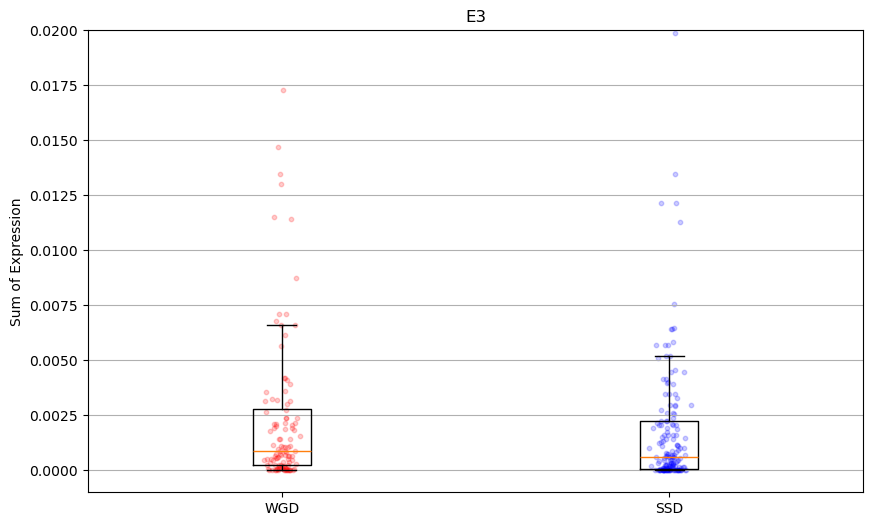

Median value of sum of expression in WGD: 0.000898
Median value of sum of expression in SSD: 0.000624
Kolmogorov-Smirnov test:	KstestResult(statistic=0.13018605645851156, pvalue=0.1840193328321584, statistic_location=0.00022999492989325435, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=10619.0, pvalue=0.0551532262503509)


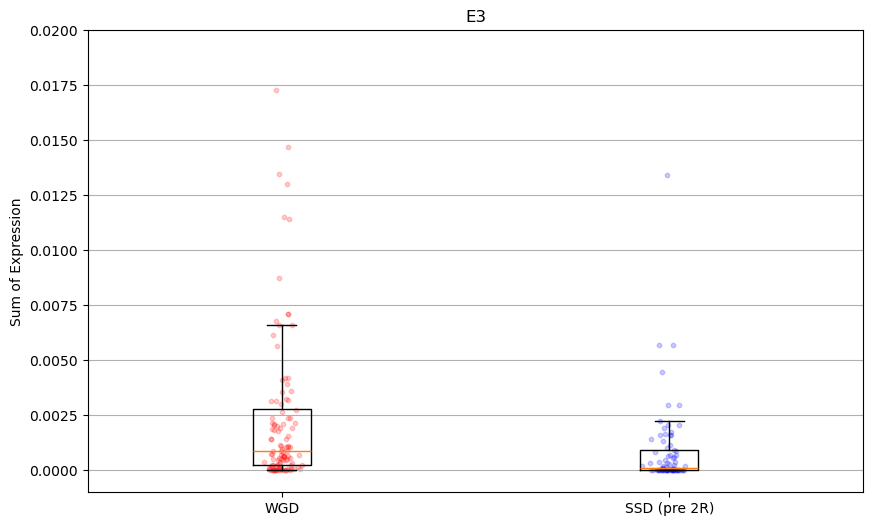

Median value of sum of expression in WGD: 0.000898
Median value of sum of expression in SSD (pre 2R): 0.000122
Kolmogorov-Smirnov test:	KstestResult(statistic=0.3327922077922078, pvalue=5.419731391648984e-05, statistic_location=0.00037393706875552766, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6173.0, pvalue=4.668267511298582e-07)


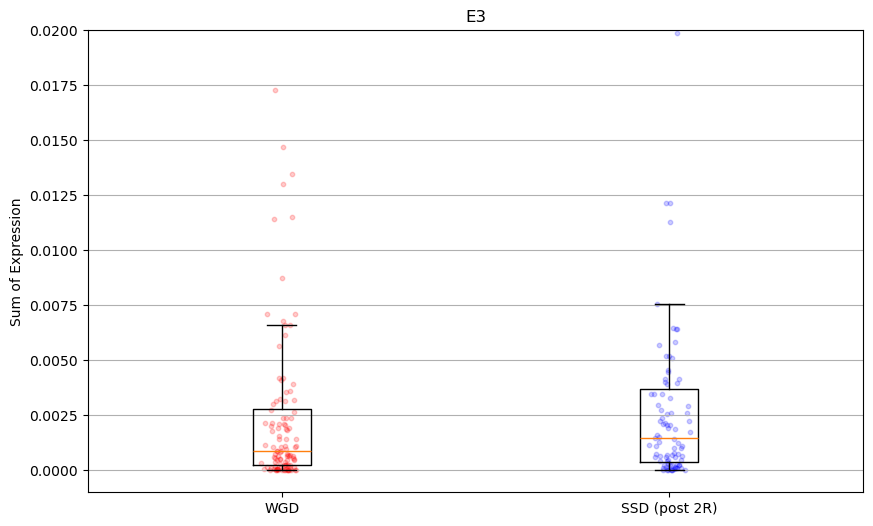

Median value of sum of expression in WGD: 0.000898
Median value of sum of expression in SSD (post 2R): 0.001485
Kolmogorov-Smirnov test:	KstestResult(statistic=0.125, pvalue=0.37499768284841656, statistic_location=0.0010895653975925598, statistic_sign=1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=4509.5, pvalue=0.15918342633854976)


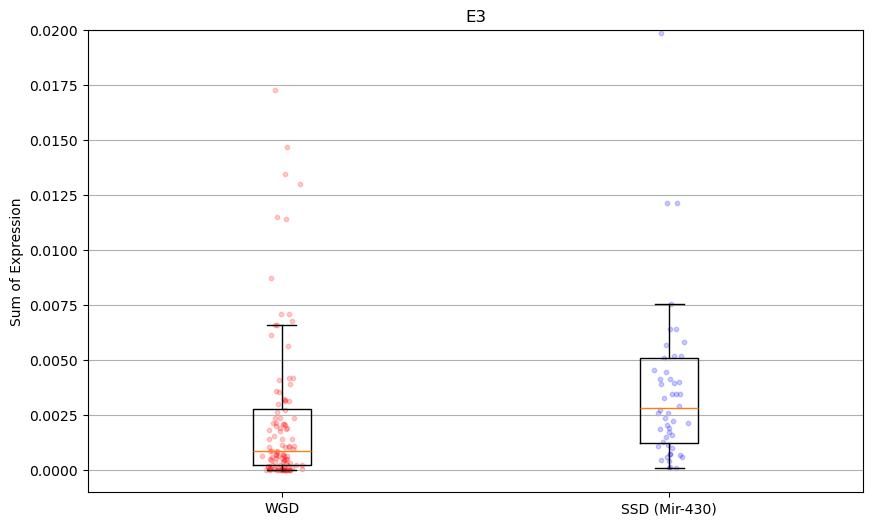

Median value of sum of expression in WGD: 0.000898
Median value of sum of expression in SSD (Mir-430): 0.002828
Kolmogorov-Smirnov test:	KstestResult(statistic=0.35096153846153844, pvalue=0.00020840390216998316, statistic_location=0.0011191390853119484, statistic_sign=1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=1770.0, pvalue=5.486896870917888e-05)


In [31]:
label = 'E3'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

### Embryonic stage: E4

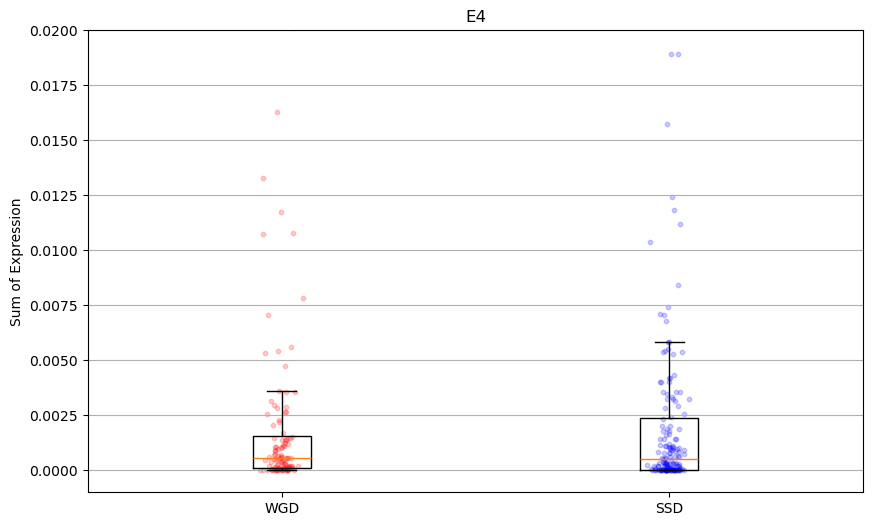

Median value of sum of expression in WGD: 0.000558
Median value of sum of expression in SSD: 0.000497
Kolmogorov-Smirnov test:	KstestResult(statistic=0.13510479041916168, pvalue=0.15442178578918048, statistic_location=9.620825248297362e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=9765.5, pvalue=0.531835738557582)


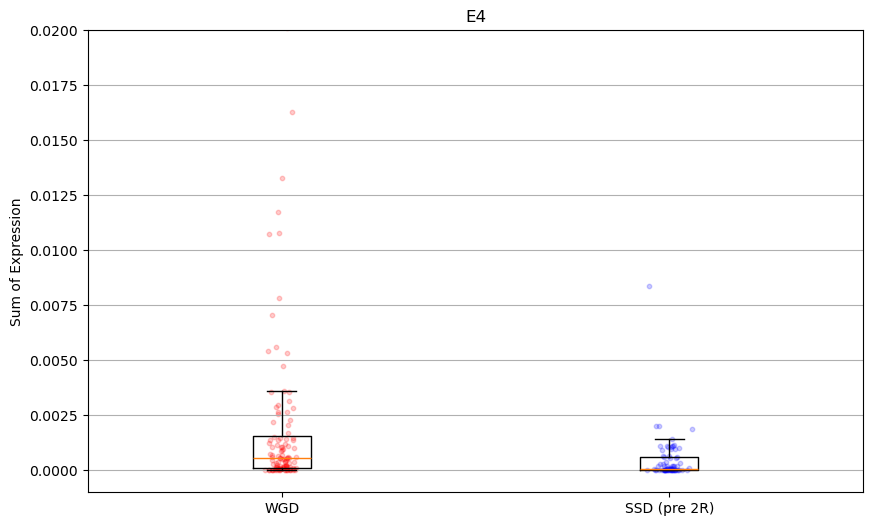

Median value of sum of expression in WGD: 0.000558
Median value of sum of expression in SSD (pre 2R): 7.5e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.31412337662337664, pvalue=0.00017168444895331692, statistic_location=9.620825248297362e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6184.0, pvalue=4.077026267983773e-07)


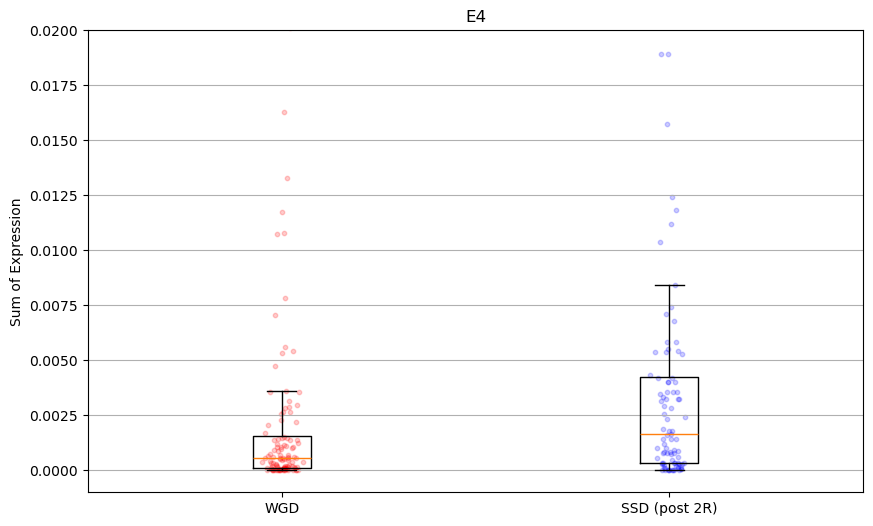

Median value of sum of expression in WGD: 0.000558
Median value of sum of expression in SSD (post 2R): 0.001627
Kolmogorov-Smirnov test:	KstestResult(statistic=0.27266483516483514, pvalue=0.0008640754837915932, statistic_location=0.0014101893734946695, statistic_sign=1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=3637.5, pvalue=0.0004605273605812569)


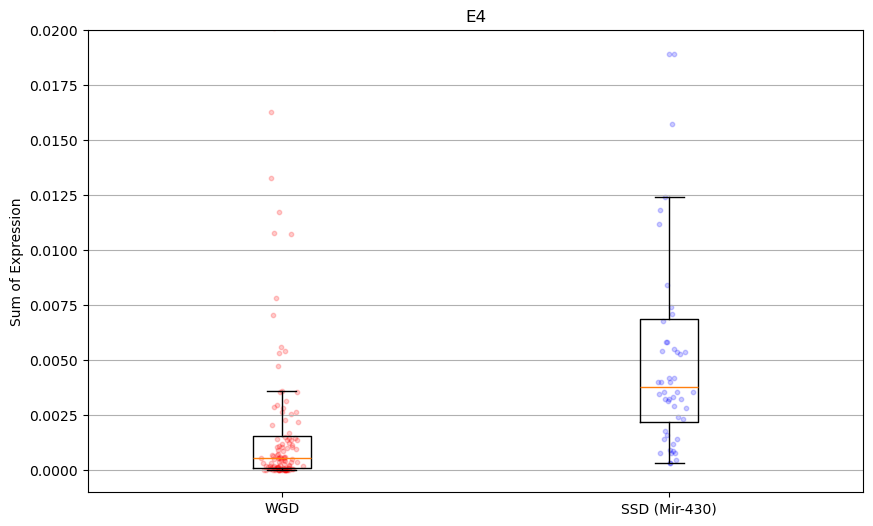

Median value of sum of expression in WGD: 0.000558
Median value of sum of expression in SSD (Mir-430): 0.003796
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5501373626373627, pvalue=1.8890020518536057e-10, statistic_location=0.0014101893734946695, statistic_sign=1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=1024.0, pvalue=2.5573279459261424e-11)


In [32]:
label = 'E4'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

### Embryonic stage: E5

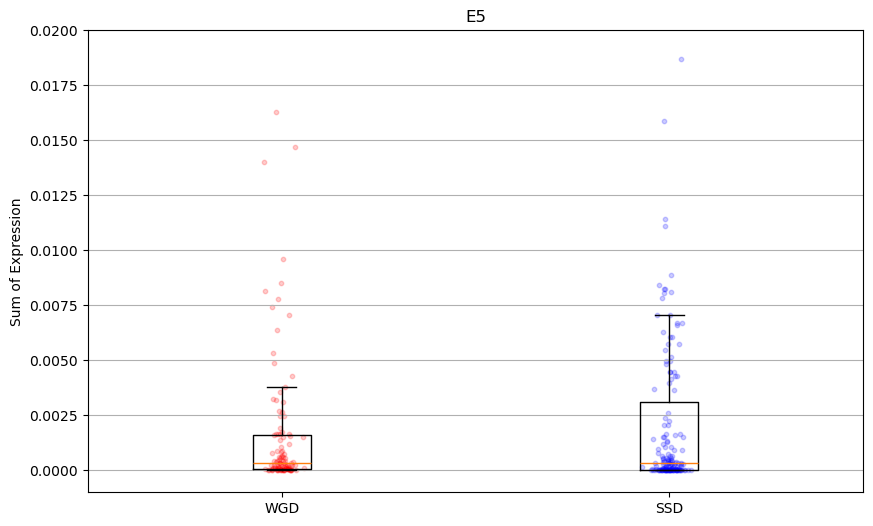

Median value of sum of expression in WGD: 0.000322
Median value of sum of expression in SSD: 0.00031
Kolmogorov-Smirnov test:	KstestResult(statistic=0.12649700598802396, pvalue=0.21049606514030772, statistic_location=0.0035738850261613085, statistic_sign=1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=9474.5, pvalue=0.8534846420191786)


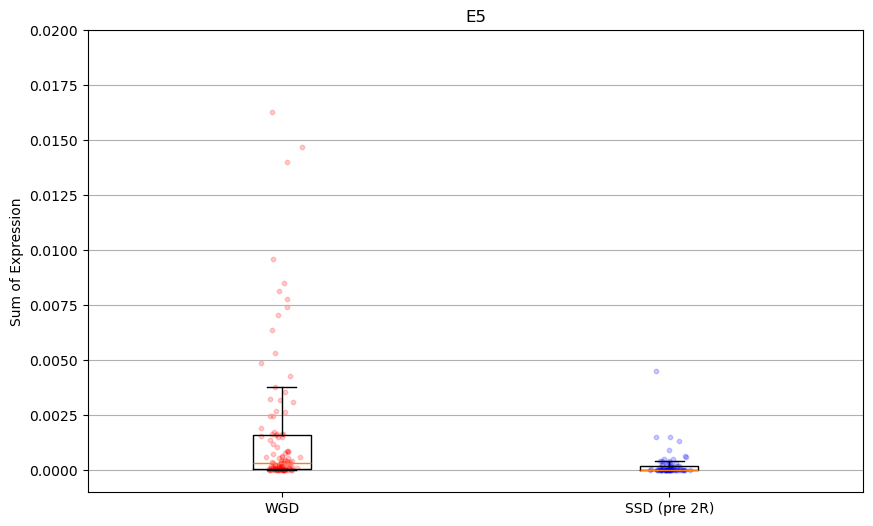

Median value of sum of expression in WGD: 0.000322
Median value of sum of expression in SSD (pre 2R): 3.5e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.37743506493506496, pvalue=2.5714799502619485e-06, statistic_location=7.982953909434521e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6367.0, pvalue=2.6988029533208374e-08)


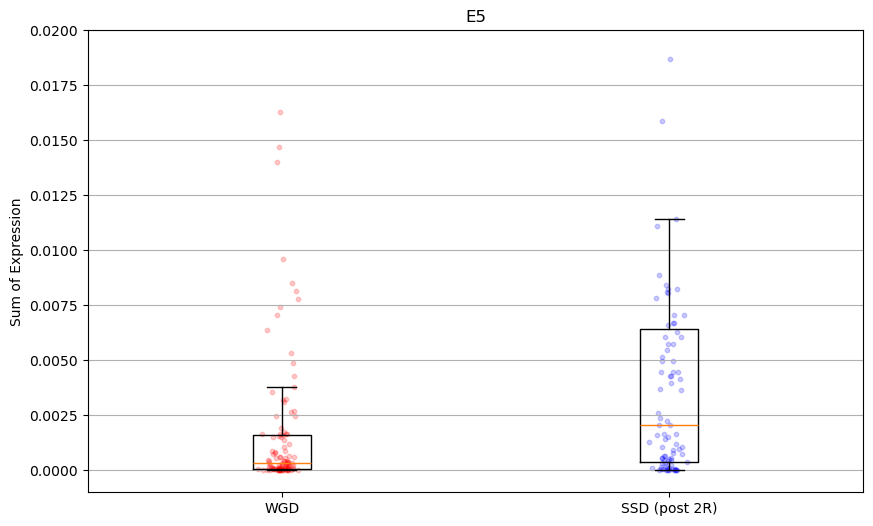

Median value of sum of expression in WGD: 0.000322
Median value of sum of expression in SSD (post 2R): 0.002043
Kolmogorov-Smirnov test:	KstestResult(statistic=0.32554945054945056, pvalue=3.1665345445999025e-05, statistic_location=0.0035738850261613085, statistic_sign=1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=3218.5, pvalue=6.5032827190673854e-06)


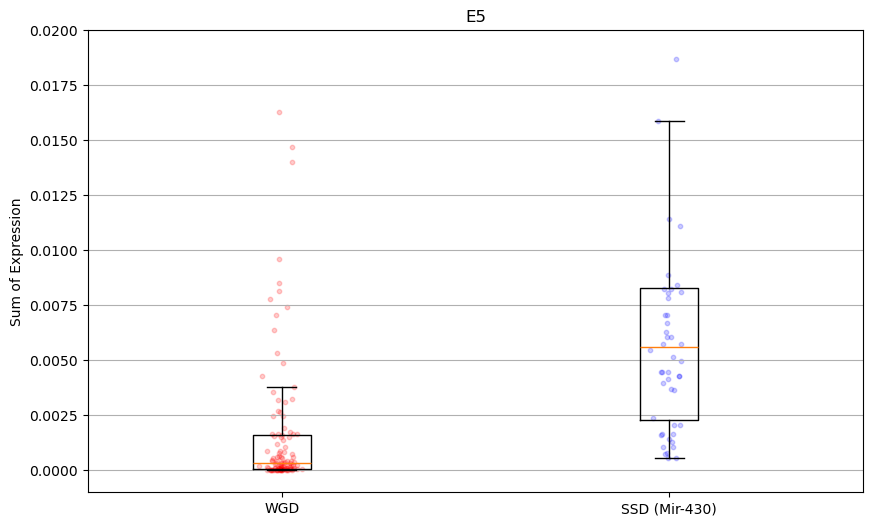

Median value of sum of expression in WGD: 0.000322
Median value of sum of expression in SSD (Mir-430): 0.005609
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6126373626373627, pvalue=4.942993189638228e-13, statistic_location=0.0016620383760631774, statistic_sign=1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=715.0, pvalue=8.361471047861015e-15)


In [33]:
label = 'E5'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

### Embryonic stage: E6

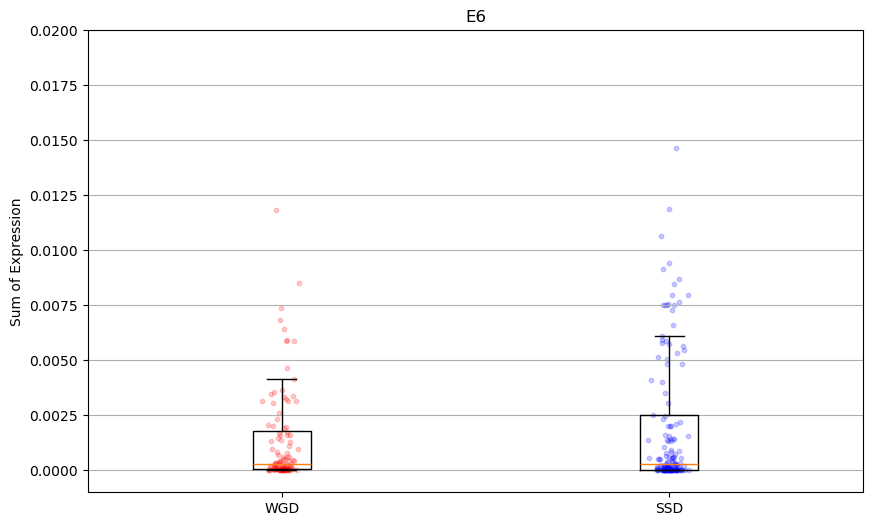

Median value of sum of expression in WGD: 0.000306
Median value of sum of expression in SSD: 0.000278
Kolmogorov-Smirnov test:	KstestResult(statistic=0.13227117194183063, pvalue=0.17145206247231484, statistic_location=0.004628160250873892, statistic_sign=1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=9408.0, pvalue=0.9330472446761343)


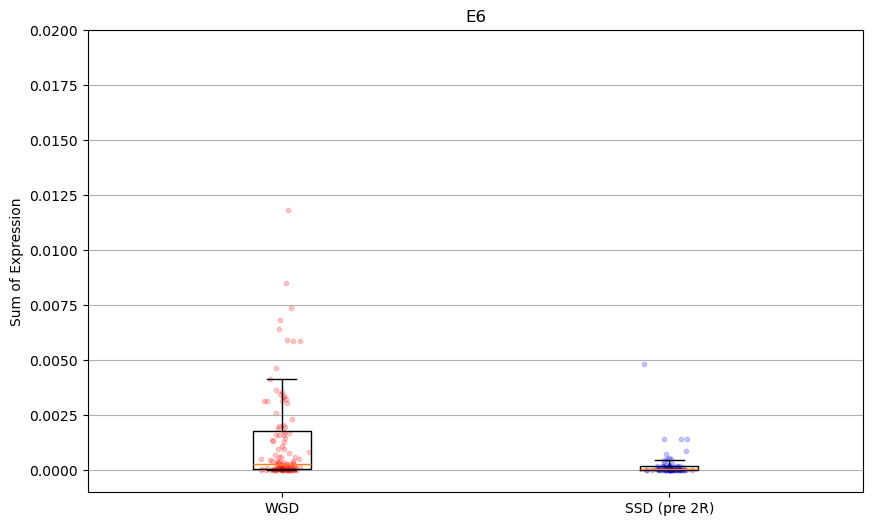

Median value of sum of expression in WGD: 0.000306
Median value of sum of expression in SSD (pre 2R): 3.8e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4017857142857143, pvalue=4.0837439521876114e-07, statistic_location=0.00027827879707302056, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6311.5, pvalue=6.312013032726373e-08)


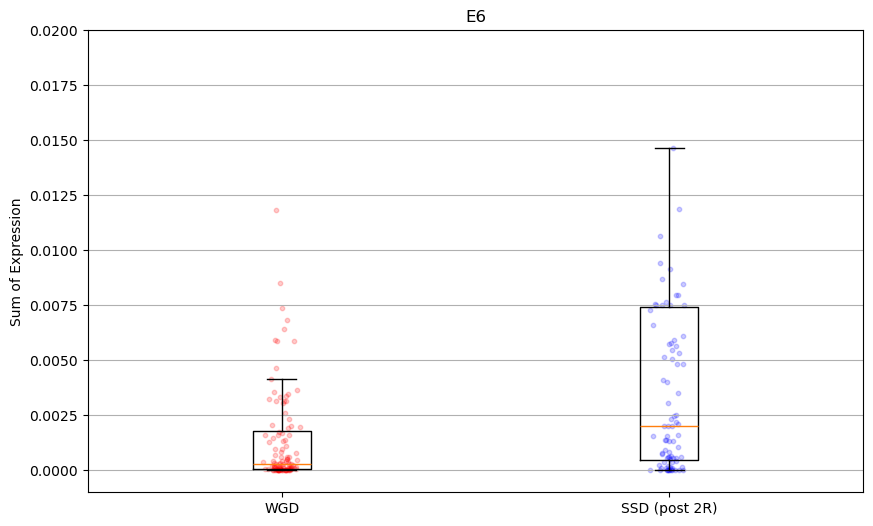

Median value of sum of expression in WGD: 0.000306
Median value of sum of expression in SSD (post 2R): 0.002028
Kolmogorov-Smirnov test:	KstestResult(statistic=0.3276098901098901, pvalue=2.7491190186894548e-05, statistic_location=0.0004978796538245553, statistic_sign=1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=3175.5, pvalue=3.975994042934327e-06)


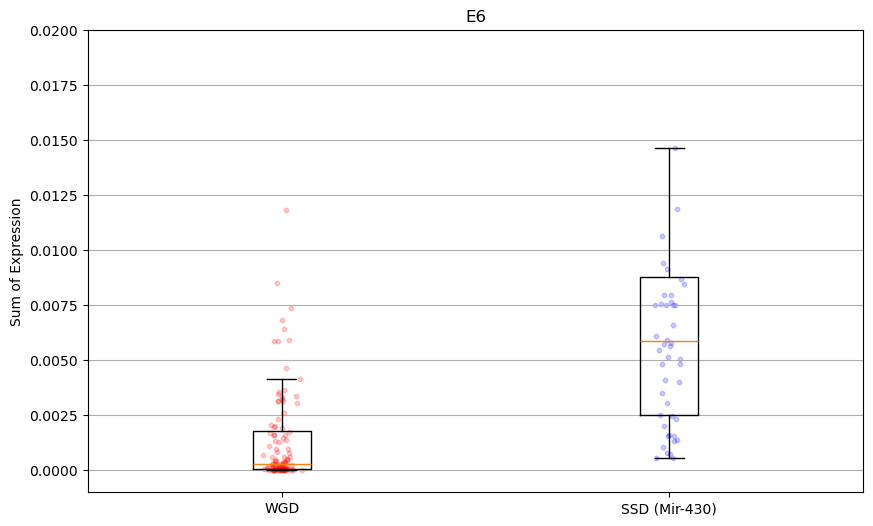

Median value of sum of expression in WGD: 0.000306
Median value of sum of expression in SSD (Mir-430): 0.00586
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5892857142857143, pvalue=4.848420528983365e-12, statistic_location=0.0005336657160375607, statistic_sign=1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=691.0, pvalue=4.26823244576269e-15)


In [34]:
label = 'E6'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)

### Embryonic stage: E7

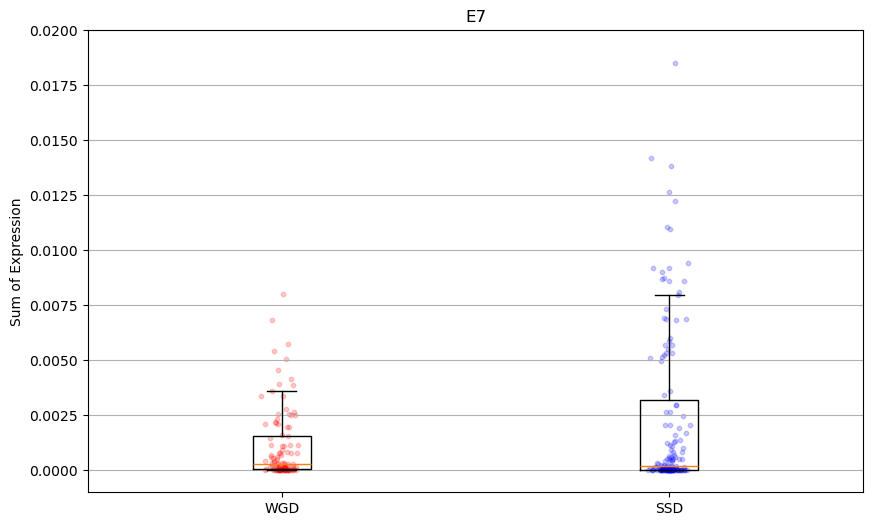

Median value of sum of expression in WGD: 0.0003
Median value of sum of expression in SSD: 0.000182
Kolmogorov-Smirnov test:	KstestResult(statistic=0.1832228400342173, pvalue=0.01868222209765023, statistic_location=1.1163144247600182e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=9582.5, pvalue=0.7276818520229162)


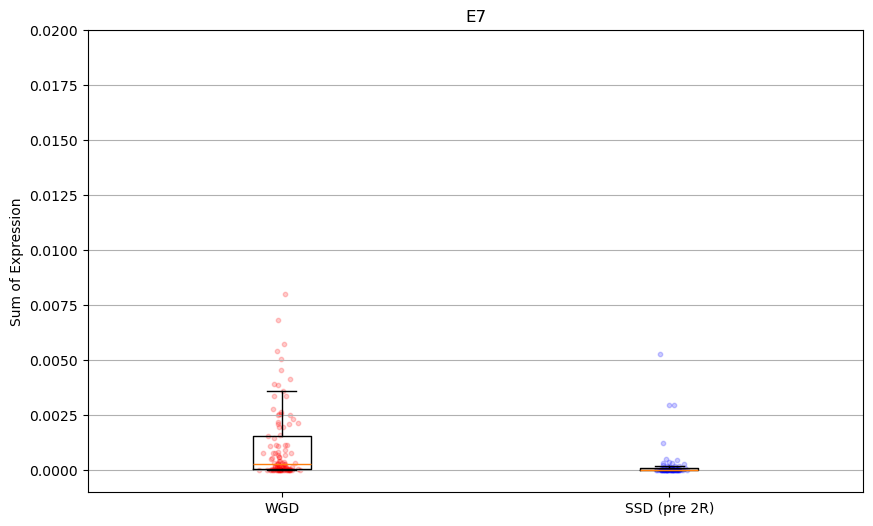

Median value of sum of expression in WGD: 0.0003
Median value of sum of expression in SSD (pre 2R): 1.3e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4310064935064935, pvalue=3.786071533283993e-08, statistic_location=9.422145090860228e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6660.0, pvalue=2.0763327768845323e-10)


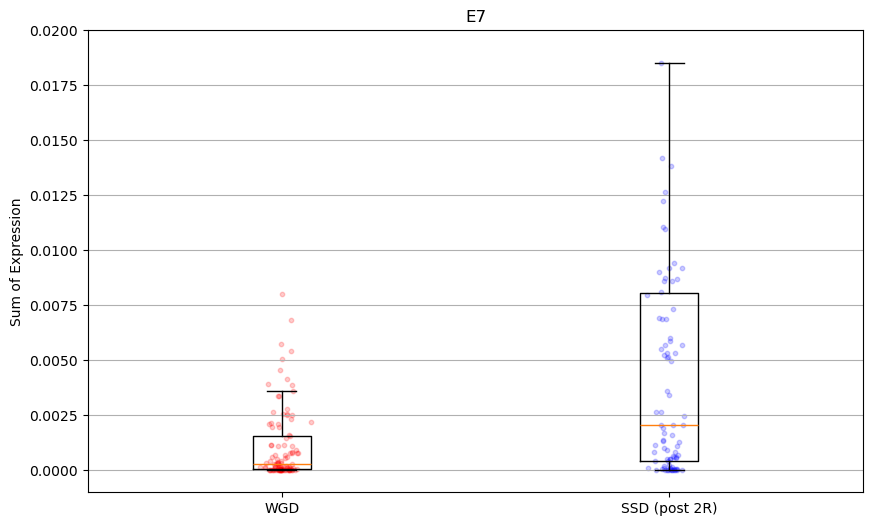

Median value of sum of expression in WGD: 0.0003
Median value of sum of expression in SSD (post 2R): 0.00208
Kolmogorov-Smirnov test:	KstestResult(statistic=0.36607142857142855, pvalue=1.6474053583764488e-06, statistic_location=0.004536032095684995, statistic_sign=1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=3030.5, pvalue=7.008202063606438e-07)


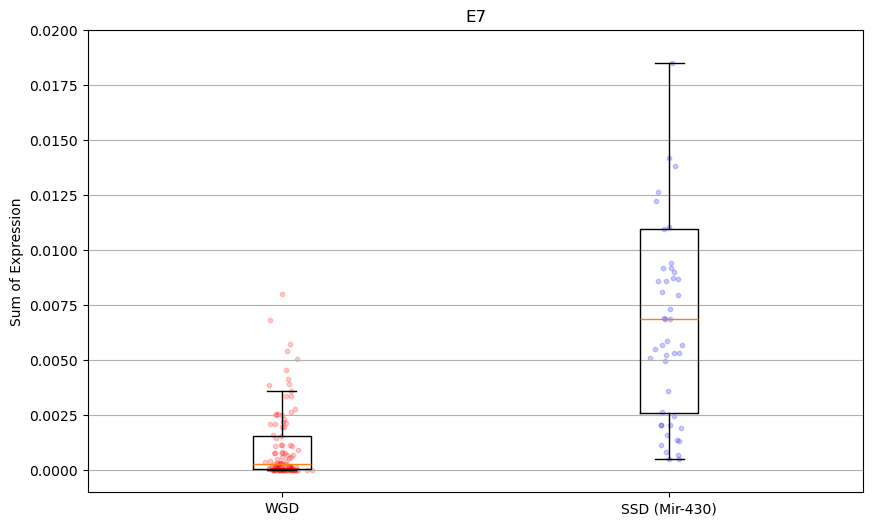

Median value of sum of expression in WGD: 0.0003
Median value of sum of expression in SSD (Mir-430): 0.006891
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6490384615384616, pvalue=9.722388480566256e-15, statistic_location=0.004536032095684995, statistic_sign=1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=537.0, pvalue=4.811852689067171e-17)


In [37]:
label = 'E7'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.001, 0.02)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.001, 0.02)